# Analysis of wage and hour case data from US state labor agencies

<font color="red">NOTE: notes in red were added on January 11, 2023 and document how we're handling new information from the Texas Workforce Commission. See notebooks/texas/texas.ipynb for more details.</font>


## Data import and preparation

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from src import shared_functions as sf
from src import constants

tqdm.pandas()
pd.set_option("display.float_format", lambda x: "%.3f" % x)


In [2]:
df = (
    pd.read_csv(
        "input/state_complaints.csv.gz",
        low_memory=False,
        parse_dates=["date_opened", "date_closed", "date_paid"],
    )
    # keep only 1 row per case. some rows contain multiple violation
    # categories, but this notebook will not address those.
    .drop_duplicates(subset="case_uuid", keep="first")
)


In [3]:
df.shape


(652155, 18)

### Data completeness


The data states provided in response to my public records requests was wildly inconsistent. I requested a long list of fields -- case statuses, start, end and paid dates, amounts claimed, assessed by the agency and paid -- but not all states possessed that data. Many states exported data directly from their case management systems, so lots of those fields were missing. This section will examine the completeness of various data points and explain how I am handling missing data. 

NOTE: the `get_coverage_df` function outputs the completeness (% non-null) of key columns in the analysis. You can find it at `shared/src/shared_functions.py`.

The data overall is very incomplete and has a ton of missing values. This is largely because many of the cases sent from case management systems are not completed. 

In [4]:
sf.get_coverage_df(df, by_state=False)


case_status       0.417
amount_claimed    0.519
amount_assessed   0.401
amount_paid       0.381
date_opened       0.985
date_closed       0.233
dtype: float64

This state breakdown heatmap shows which states have which data. 

<AxesSubplot: ylabel='state_name'>

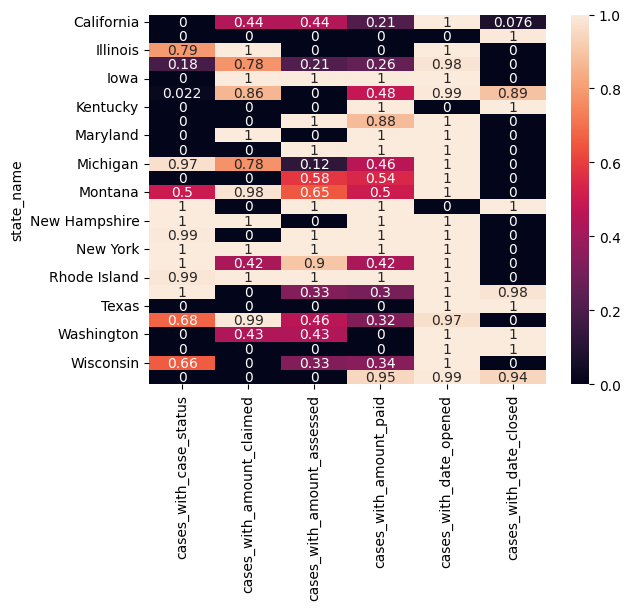

In [5]:
sns.heatmap(sf.get_coverage_df(df).iloc[:, 1:], annot=True)


The `determine_case_outcome` task of this repo assigns a `case_decided_in_favor_of_claimant` column to the dataframe, as well as the reason why that task determined the case outcome. 

In [6]:
df[
    ["case_decided_in_favor_of_claimant", "case_decided_in_favor_of_claimant_reason"]
].value_counts().to_frame("rows")


rows
case_decided_in_favor_of_claimant case_decided_in_favor_of_claimant_reason                  
True                              has amount paid                                     237082
False                             has no amount values                                178282
True                              state only provided closed cases                     62386
False                             has no assessed amount, but state provided asse...   49081
True                              has assessed amount greater than 0                   44684
False                             has assessed amount less than or equal to 0          37868
                                  has open or incomplete case status                   28539
True                              has final case status                                 9129

When you select only cases marked completed, you get much better completeness.

In [7]:
sf.get_coverage_df(df.query("case_decided_in_favor_of_claimant == True"), by_state=False)


case_status       0.450
amount_claimed    0.640
amount_assessed   0.599
amount_paid       0.672
date_opened       0.976
date_closed       0.285
dtype: float64

<AxesSubplot: ylabel='state_name'>

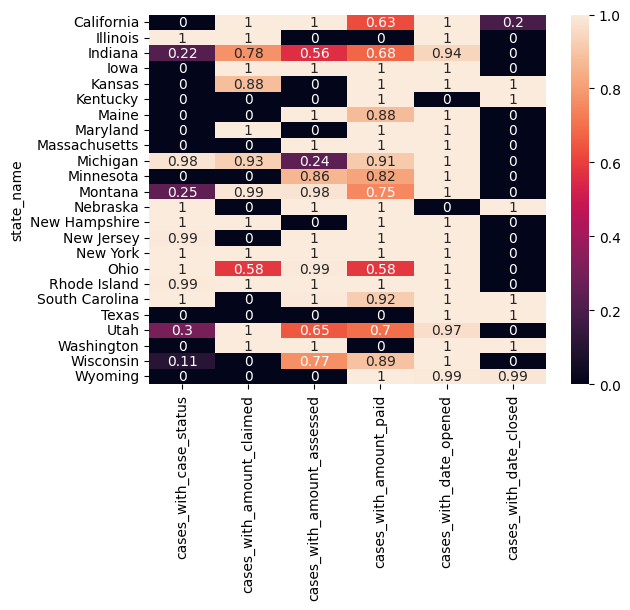

In [8]:
sns.heatmap(
    sf.get_coverage_df(df.query("case_decided_in_favor_of_claimant == True")).iloc[:, 1:],
    annot=True,
)


Texas provided data separately. Unless the AG sides with me (I'm still awaiting a decision), they determined that the amounts were private personal financial information. They did, however, provide me a file containing only the amounts that cannot be linked to the case data. For analyses of amounts, I'll add that data separately and remove the other Texas case information. 

See [shared_functions.py](../../shared/src/shared_functions.py#append_texas_amounts)


With the Texas amounts added, and incomplete cases removed, the amount fields still contain missing data but almost all cases contain at least one non-null amount. 

In [9]:
no_amounts = (
    df.pipe(sf.append_texas_amounts, filename="input/texas_amounts.csv.gz")
    .query("case_decided_in_favor_of_claimant == True")
    .query("amount_claimed.isnull() &  amount_assessed.isnull() & amount_paid.isnull()")
)
atleast_one_amount = df.query("case_decided_in_favor_of_claimant == True").query(
    "amount_claimed.notnull() | amount_assessed.notnull() | amount_paid.notnull()"
)
print(
    f"{no_amounts.shape[0]} rows "
    f"(%{no_amounts.shape[0]/len(df.query('case_decided_in_favor_of_claimant == True')) * 100:,}) "
    "have no amounts"
)


396 rows (%0.11209207401473614) have no amounts


There are also indeterminate cases, in which I couldn't determine whether the case was completed 

In [10]:
df[df.case_status == "amount exceeds statutory limit"].size


5850

## Analysis

Below you will find basic descriptive statistics and state breakdowns. I will expand on this in the coming days, including by making comparisons to average household income and consumer expenses. 1 

I will focus on the following data points: 
1. overall amount assessed and the impacts that can have
2. amount claimed or assessed by the state vs. the amount paid by the company
3. the amount of time these cases take to resolve


All cases used in this analysis are decided in favor of the claimant unless otherwise specified. 

### Overall case amounts

In [11]:
len(df.query("case_decided_in_favor_of_claimant == True")) / len(df)

0.5417132430173809

In [12]:
amount_df = (
    df.query("case_decided_in_favor_of_claimant == True")
    # appending texas to the end of the state name because there are
    # amounts stored separately
    .pipe(sf.append_texas_amounts, filename="input/texas_amounts.csv.gz")
)
amount_df.overall_case_amount.describe()


count    352347.000
mean       4553.814
std       30456.465
min           0.000
25%         200.000
50%         719.160
75%        2394.805
max     5912348.830
Name: overall_case_amount, dtype: float64

In [13]:
print(f"Total amount across all states: {amount_df.overall_case_amount.sum():,.0f}")


Total amount across all states: 1,604,522,647


In [14]:
(
    amount_df.groupby(
        pd.cut(
            amount_df.overall_case_amount,
            [
                0,
                100,
                500,
                1000,
                2500,
                5000,
                10000,
                50000,
                100000,
                500000,
                1000000,
                99999999999999,
            ],
        )
    )
    .size()
    .to_frame("total_cases")
    .rename(
        index={
            pd.Interval(0, 100, closed="right"): "$0 - $100",
            pd.Interval(100, 500, closed="right"): "$100 - $500",
            pd.Interval(500, 1000, closed="right"): "$500 - $1,000",
            pd.Interval(1000, 2500, closed="right"): "$1,000 - $2,500",
            pd.Interval(2500, 5000, closed="right"): "$2,500 - $5,000",
            pd.Interval(5000, 10000, closed="right"): "$5,000 - $10,000",
            pd.Interval(10000, 50000, closed="right"): "$10,000 - $50,000",
            pd.Interval(50000, 100000, closed="right"): "$50,000 - $100,000",
            pd.Interval(100000, 500000, closed="right"): "$100,000 - $500,000",
            pd.Interval(500000, 1000000, closed="right"): "$500,000 - $1,000,000",
            pd.Interval(1000000, 99999999999999, closed="right"): "$1,000,000+",
        }
    )
    .assign(pct_of_total_cases=lambda df: df.total_cases / df.total_cases.sum())
)


,total_cases,pct_of_total_cases
overall_case_amount,,
$0 - $100,24918,0.079
$100 - $500,84769,0.270
"$500 - $1,000",56863,0.181
"$1,000 - $2,500",62562,0.199
"$2,500 - $5,000",34123,0.109
"$5,000 - $10,000",23421,0.075
"$10,000 - $50,000",22479,0.072
"$50,000 - $100,000",2712,0.009
"$100,000 - $500,000",1973,0.006


In [15]:
amount_df.groupby("state_name").overall_case_amount.sum().to_frame("overall_case_amount").join(
    amount_df.groupby("state_name").overall_case_amount.describe()
)


,overall_case_amount,count,mean,std,min,25%,50%,75%,max
state_name,,,,,,,,,
California,558617653.636,63442.000,8805.171,44730.691,0.000,295.025,2070.010,6955.500,5912348.830
Illinois,22659418.280,6951.000,3259.879,24793.775,0.000,340.000,960.000,2440.540,1923000.000
Indiana,39404254.013,7832.000,5031.187,51612.102,0.000,245.642,590.550,1524.862,2297378.000
Iowa,853899.000,7370.000,115.861,625.433,0.000,0.000,0.000,0.000,7625.000
Kansas,10508991.876,4931.000,2131.209,29528.906,0.440,250.000,560.000,1280.500,2019015.000
Kentucky,23838093.630,7020.000,3395.740,16168.527,25.380,207.765,398.645,1164.223,125810.820
Maine,1977300.070,792.000,2496.591,8276.580,2.750,222.040,585.750,1551.312,153993.440
Maryland,20140568.600,8290.000,2429.502,6628.096,0.000,384.000,934.470,2200.000,287701.580
Massachusetts,48474294.560,2419.000,20038.981,75475.087,0.000,857.320,2560.000,9826.160,1325287.250


### Amounts recovered

<font color="red">For Texas paid amounts, we have been told by the Texas Workforce Commission that they do not reliably track the amounts paid, but rather use a numeric status code that was included in the original data to designate if payment was made. For calculations of percentages of cases paid, we will use that status code to designate whether a case was paid, and for total amounts recovered we will use the actual paid amount field, even though it is incomplete.</font>

In [16]:
texas_raw = (
    pd.read_excel(
        "input/Copy_of_RESULTS_-_MEDIA_REQUEST_-_January_1_2010_to_Jul_14_2022.xlsx"
    )
    # dedupe, select only awarded cases and remove rows that need to be removed (see texas notebook)
    .drop_duplicates("WAGE_CLAIM_ID")
    # there are some records in Texas that are marked as not awarded but have amounts paid. We are 
    # considering those to be awarded for this analysis
    .query("AWARDED == 'YES' | FK_VCMPLNT_STSCD.isin(@constants.TX_PAID_STATUS_CODES)")
    # ensure it's an int before searching for it in the list
    .assign(FK_VCMPLNT_STSCD=lambda x: x.FK_VCMPLNT_STSCD.astype(int))
    .query("~FK_VCMPLNT_STSCD.isin(@constants.TX_DROP_STATUS_CODES)")
)


texas_totals = (
    texas_raw.assign(
        paid=lambda x: x.FK_VCMPLNT_STSCD.astype(int).isin(
            constants.TX_PAID_STATUS_CODES
        )
    )
    # there are some records in Texas that are marked as not awarded but have amounts paid. We are
    # considering those to be awarded for this analysis
    .query("AWARDED == 'YES' | paid == True")
    # these are withdrawn cases, which we are not considering for this analysis
    # because their outcomes are indeterminate
    .query("~FK_VCMPLNT_STSCD.isin(@constants.TX_DROP_STATUS_CODES)")
    .groupby("paid")
    .WAGE_CLAIM_ID.nunique()
    .to_frame("n")
    .transpose()
    .assign(total=lambda x: x[True] + x[False])
    .assign(pct_true=lambda x: x[True] / x["total"])
)

texas_totals


paid,False,True,total,pct_true
n,25742,36539,62281,0.587


In [17]:
paid_df = (
    amount_df.assign(
        amount_claimed_or_assessed=lambda df: df.apply(
            lambda row: row.amount_assessed
            if pd.notna(row.amount_assessed)
            else row.amount_claimed,
            axis=1,
        )
    )
    # only use rows from states that provided paid amounts and assessed or claimed amounts
    .pipe(
        lambda df: df[
            df.state_name.isin(
                sf.get_coverage_df(amount_df)
                .query(
                    "cases_with_amount_paid > 0 & (cases_with_amount_claimed > 0 | cases_with_amount_assessed > 0)"
                )
                .index
            )
        ]
    )
)

paid_case_totals = (
    paid_df.query("state_name != 'Texas'")
    .assign(has_amount_paid=lambda df: df.amount_paid.notnull() & df.amount_paid > 0)
    .has_amount_paid.value_counts()
    .to_frame("total_cases")
    .add(
        # add texas data and convert it into the same format as this table
        texas_totals.transpose()
        .query("index.isin([True, False])")
        .rename(columns={"n": "total_cases"})
    )
    .assign(pct_of_total_cases=lambda df: df.total_cases / df.total_cases.sum())
)

paid_case_totals


,total_cases,pct_of_total_cases
False,126551.000,0.383
True,204067.000,0.617


In [18]:
print(f"Total amount paid: ${paid_df.amount_paid.sum():,.0f}")


Total amount paid: $631,838,076


In [19]:
texas_paid = paid_df.query("state_name == 'Texas'")

pd.Series(
    {
        "total_cases": texas_paid.shape[0],
        "cases_with_paid_amounts": (
            texas_raw.query("FK_VCMPLNT_STSCD.isin([950, 970])").shape[0]
        ),
        "total_amount_paid": texas_paid.amount_paid.sum(),
        "pct_of_total_cases": texas_raw.query(
            "FK_VCMPLNT_STSCD.isin([950, 970])"
        ).shape[0]
        / texas_raw.shape[0],
    },
    name="Texas",
)


paid_by_state = (
    paid_df.query("state_name != 'Texas'")
    .groupby("state_name")
    .size()
    .to_frame("total_cases")
    .join(
        paid_df.query("amount_paid > 0")
        .groupby("state_name")
        .size()
        .to_frame("cases_with_paid_amounts")
    )
    .join(paid_df.groupby("state_name").amount_paid.sum().to_frame("total_amount_paid"))
    .assign(
        pct_of_total_cases=lambda df: df.cases_with_paid_amounts / df.total_cases,
    )
    .transpose()
    .assign(
        Texas=texas_totals.rename(
            columns={
                True: "cases_with_paid_amounts",
                "total": "total_cases",
                "pct_true": "pct_of_total_cases",
            },
            index={"n": "Texas"},
        )
        .drop(columns=False)
        .iloc[0]
    )
    .transpose()
)

paid_by_state


,total_cases,cases_with_paid_amounts,total_amount_paid,pct_of_total_cases
state_name,,,,
California,63442.000,26509.000,126853456.268,0.418
Indiana,8175.000,5541.000,3645489.950,0.678
Iowa,7370.000,3199.000,2617419.000,0.434
Kansas,4931.000,4931.000,10508991.876,1.000
Maine,792.000,690.000,1451891.010,0.871
Maryland,8290.000,5102.000,8346019.710,0.615
Massachusetts,2419.000,2408.000,48474294.560,0.995
Michigan,41787.000,37796.000,36834248.610,0.904
Minnesota,745.000,606.000,5319233.840,0.813


### Case duration

In [20]:
duration_df = (
    df.query("case_decided_in_favor_of_claimant == True")
    .copy()
    .assign(case_duration=lambda x: x.date_closed - x.date_opened)
    .assign(duration_days=lambda x: x.case_duration.dt.days)
)

duration_df.case_duration.describe()


count                          92920
mean     310 days 16:15:04.139552208
std      410 days 08:37:45.687898972
min                  0 days 00:00:00
25%                106 days 00:00:00
50%                196 days 00:00:00
75%                337 days 00:00:00
max               4585 days 00:00:00
Name: case_duration, dtype: object

In [21]:
(
    duration_df.groupby(
        pd.cut(duration_df.duration_days, [0, 30, 60, 90, 180, 360, 720, 999999])
    )
    .size()
    .to_frame("total_cases")
    .rename(
        index={
            pd.Interval(0, 30, closed="right"): "0-30 days",
            pd.Interval(30, 60, closed="right"): "30-60 days",
            pd.Interval(60, 90, closed="right"): "60-90 days",
            pd.Interval(90, 180, closed="right"): "90-180 days",
            pd.Interval(180, 360, closed="right"): "180-360 days",
            pd.Interval(360, 720, closed="right"): "360-720 days",
            pd.Interval(720, 999999, closed="right"): "720+ days",
        }
    )
    .assign(pct_of_total_cases=lambda df: df.total_cases / df.total_cases.sum())
)


,total_cases,pct_of_total_cases
duration_days,,
0-30 days,4594,0.049
30-60 days,5104,0.055
60-90 days,8446,0.091
90-180 days,24617,0.265
180-360 days,29375,0.316
360-720 days,13297,0.143
720+ days,7387,0.080


In [22]:
duration_df.groupby("state_name").duration_days.describe().dropna()


,count,mean,std,min,25%,50%,75%,max
state_name,,,,,,,,
California,12366.000,523.836,306.061,26.000,300.000,439.000,676.750,1951.000
Kansas,4917.000,158.355,306.790,0.000,47.000,99.000,168.000,3869.000
South Carolina,4807.000,65.342,48.877,0.000,35.000,57.000,84.000,826.000
Texas,62386.000,332.346,446.831,29.000,133.000,209.000,324.000,4585.000
Washington,6364.000,55.863,55.484,0.000,22.000,43.000,69.000,1197.000
Wyoming,2080.000,99.992,137.802,0.000,24.000,48.000,124.000,1114.000


### Comparison to state felony theft thresholds


In [23]:
felony_thresholds = (
    pd.read_csv("input/felony_thresholds.csv")[["state_name", "felony_theft_threshold"]]
    .set_index("state_name")
    .to_dict(orient="index")
)

felony_threshold_df = (
    df
    .pipe(sf.append_texas_amounts, filename="input/texas_amounts.csv.gz")
    .assign(
        felony_theft_threshold=lambda d: d.state_name.map(felony_thresholds).apply(
            lambda x: x["felony_theft_threshold"]
        )
    )
    .assign(felony_theft=lambda d: d.overall_case_amount >= d.felony_theft_threshold)
)

(
    felony_threshold_df.groupby("felony_theft")
    .size()
    .to_frame("total_cases")
    .assign(pct_of_total_cases=lambda d: d.total_cases / d.total_cases.sum())
)


,total_cases,pct_of_total_cases
felony_theft,,
False,475856,0.729
True,177071,0.271


In [24]:
felony_theft_thresholds = (
    pd.crosstab(
        index=[
            felony_threshold_df.state_name,
            felony_threshold_df.felony_theft_threshold,
        ],
        columns=felony_threshold_df.felony_theft,
    )
    .pipe(lambda d: pd.concat([d, d.sum().to_frame("total").T]))
    .assign(
        total=lambda d: d[True] + d[False],
        pct=lambda d: d[True] / d.total,
        state_name=lambda d: d.index.map(lambda x: x[0] if isinstance(x, tuple) else x),
        felony_theft_threshold=lambda d: d.index.map(lambda x: x[1] if isinstance(x, tuple) else x),
    )
    .set_index(["state_name", "felony_theft_threshold"])
)
felony_theft_thresholds


,felony_theft,False,True,total,pct
state_name,felony_theft_threshold,,,,
California,950.0,150618,39609,190227,0.208
Colorado,2000.0,454,0,454,0.000
Illinois,500.0,7470,16339,23809,0.686
Indiana,750.0,12821,8690,21511,0.404
Iowa,1000.0,7090,280,7370,0.038
Kansas,1500.0,7171,3080,10251,0.300
Kentucky,500.0,3978,3159,7137,0.443
Maine,1000.0,520,272,792,0.343
Maryland,1500.0,5364,2926,8290,0.353


In [25]:
felony_theft_thresholds.to_csv("output/felony_theft_by_state.csv")
